# Brick-image pre-processing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import cv2 #Opencv
from google.colab.patches import cv2_imshow
import os
import numpy as np
import matplotlib.pyplot as plt

## 얼굴 사이즈 보정

### [Part 1] opencv simple face detection 모듈 불러와서 실험하기
> 실험결과 : 레고는 사람 얼굴 탐지 모델로 탐지 불가

이미지 기본 정보 : https://nonegom.github.io/ml_preprocessing/2020/11/11/Preprocessing06/  
https://opencv-python.readthedocs.io/en/latest/index.html  

이미지에서 얼굴을 감지하여 자르는 방법 : https://yoursource.tistory.com/106  
opencv 모듈에서 확인하기 : https://overface.tistory.com/573  

In [ ]:
#!git clone https://github.com/opencv/opencv.git

In [ ]:
#사람 얼굴 인식기 레고에서 테스트
faceCascade = cv2.CascadeClassifier('opencv/data/haarcascades/haarcascade_frontalface_default.xml')

In [ ]:
def detect_face(gray,frame):
    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5,minSize=(100,100),flags=cv2.CASCADE_SCALE_IMAGE)
    
    for(x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        
        face_gray=gray[y:y+h,x:x+w]
        face_color=frame[y:y+h,x:x+w]
                    
    return frame

In [ ]:
def get_image(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  c = detect_face(gray, img)
  cv2_imshow(c)

In [ ]:
get_image('/content/drive/MyDrive/human.jpeg')

In [ ]:
get_image('/content/drive/MyDrive/images/lego_1_0.jpg') #사람 이미지 경로와 레고 이미지 경로 비교

### [Part 2] image resize & contouring
참고자료 : https://076923.github.io/posts/Python-opencv-9/  
> 1. 이미지에서 임의로 자르는 방식 : 깔끔한 전처리가 진행되질 않음
> 2. 이미지에서 물체의 윤곽선을 기준으로 자르는 방식, 참고자료 : https://youbidan.tistory.com/19  
> 3. 해리슨 코너 검출법, 참고자료 : http://www.gisdeveloper.co.kr/?p=6765  

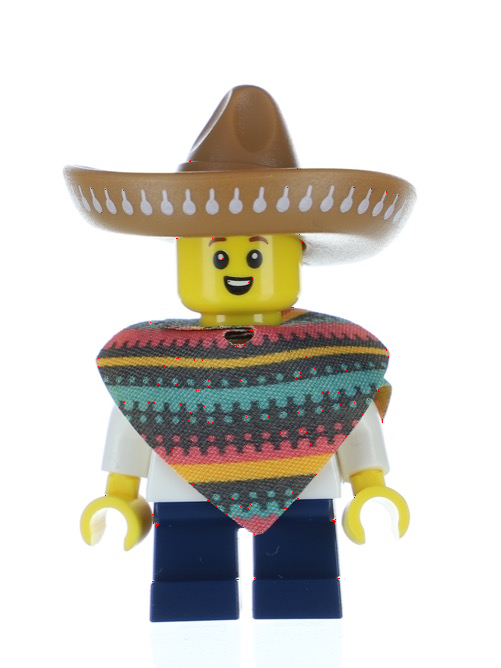

In [31]:
#해리슨 코너 검출법, 원하는 부분이 코너로 검출되지 않아서 넘긴다
test = cv2.imread("/content/drive/MyDrive/images/lego_16_0.jpg", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.1)
test[dst>0.01*dst.max()]=[0,0,255]
cv2_imshow(test)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
src = cv2.imread("/content/drive/MyDrive/images/lego_100_0.jpg", cv2.IMREAD_COLOR)
dst = src[0:300, 130:400].copy()

cv2_imshow(src)
cv2_imshow(dst)

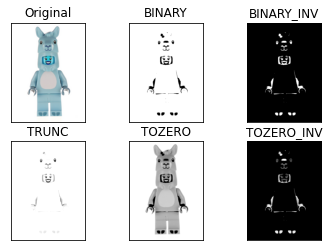

In [189]:
#레고 얼굴을 가장 잘 찾는 threshold옵션 찾기
from matplotlib import pyplot as plt
src = cv2.imread("/content/drive/MyDrive/images/lego_10_0.jpg", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
ret, thresh3 = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)
ret, thresh4 = cv2.threshold(gray, 127, 255, cv2.THRESH_TOZERO)
ret, thresh5 = cv2.threshold(gray, 127, 255, cv2.THRESH_TOZERO_INV)

titles =['Original','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [src,thresh1,thresh2,thresh3,thresh4,thresh5]

for i in range(6):
	plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
	plt.title(titles[i])
	plt.xticks([]),plt.yticks([])

윤곽선 찾기

In [12]:
#이미지 내의 전체 윤곽선 찾기
src = cv2.imread("/content/drive/MyDrive/images/lego_16_0.jpg", cv2.IMREAD_COLOR)
print("이미지 사이즈 확인 :", src.shape)

이미지 사이즈 확인 : (668, 501, 3)


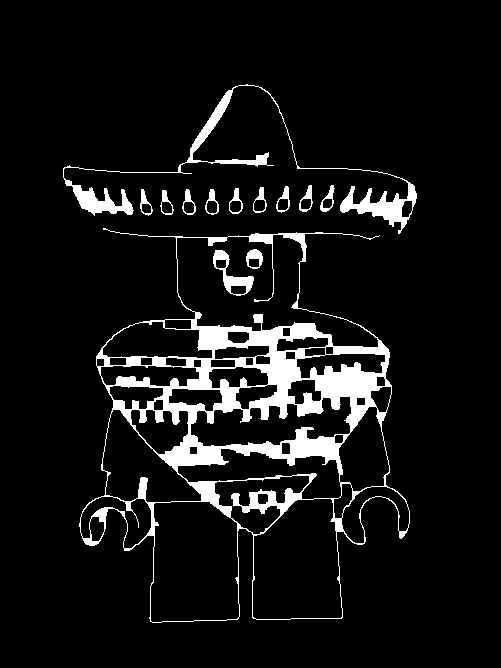

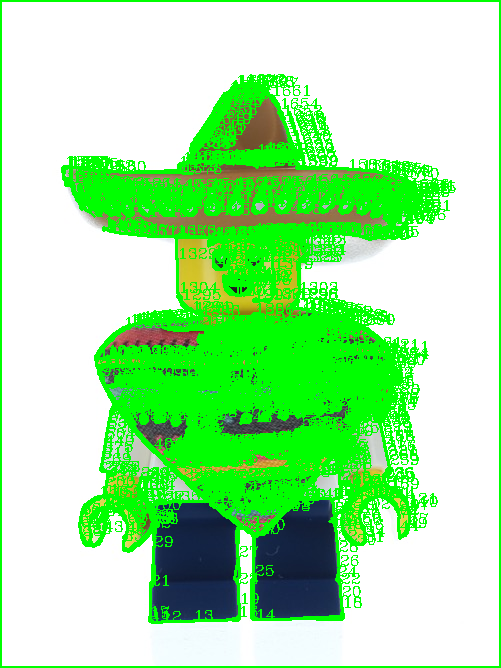

In [13]:
gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, ksize=(3,3), sigmaX=0) #가우시안 블러를 사용하여
edged = cv2.Canny(blur, 10, 250) #외곽선을 찾는다
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
cv2_imshow(closed)
ret, binary = cv2.threshold(edged, 127, 255, cv2.THRESH_TOZERO) #closed기준으로 외곽선 추출시 이미지 가장자리 윤곽선또한 포함되는 문제 발생, blur기준으로 진행
binary = cv2.bitwise_not(binary)

contours, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS) #cv2.findContours(이진화 이미지, 검색 방법, 근사화 방법)

#hierarchy는 [다음 윤곽선, 이전 윤곽선, 내곽 윤곽선, 외곽 윤곽선]의 형태로 값이 저장 되어 있다
for i in range(len(contours)):
    cv2.drawContours(src, [contours[i]], 0, (0, 255, 0), 2) #cv2.drawContours(이미지, [윤곽선], 윤곽선 인덱스, (B, G, R), 두께, 선형 타입)
    cv2.putText(src, str(i), tuple(contours[i][0][0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1)
cv2_imshow(src)
cv2.destroyAllWindows()

In [14]:
print("윤곽선 수 :", len(hierarchy[0]))
print(hierarchy[0][0])

윤곽선 수 : 1673
[ 1 -1 -1 -1]


In [15]:
contours_xy = np.array(contours)
contours_xy.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(1673,)

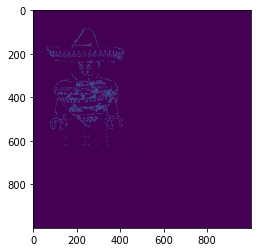

In [16]:
#numpy 배열로 변환한 contours의 좌표를 찍어보자
canvas = np.zeros((1000,1000),dtype=np.uint8)

for contour in contours:
  contour = contour.squeeze(1) #차원 내리기
  canvas[contour.T[1],contour.T[0]] = 1

plt.imshow(canvas)

팔 기준으로 윤곽선 찾기(x축, y축)

In [17]:
hand_x_min, hand_x_max = float('inf'), float('-inf')
hand_y_left, hand_y_right = 0, 0
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      if not contours_xy[i][j][0][0] == 0 and hand_x_min > contours_xy[i][j][0][0]:
        hand_x_min = contours_xy[i][j][0][0]
        hand_y_left = contours_xy[i][j][0][1]
      if not contours_xy[i][j][0][0] == 500 and hand_x_max < contours_xy[i][j][0][0]:
        hand_x_max = contours_xy[i][j][0][0]
        hand_y_right = contours_xy[i][j][0][1]

print("가장 왼쪽 윤곽선 :", [hand_x_min, hand_y_left])
print("가장 오른쪽 윤곽선 :", [hand_x_max, hand_y_right])

가장 왼쪽 윤곽선 : [62, 168]
가장 오른쪽 윤곽선 : [417, 198]


머리, 발 기준으로 윤곽선 찾기(y축)

In [29]:
# y의 min과 max 찾기
y_min, y_max = 0,0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 y의 값
value.sort()
y_min = value[2]
y_max = value[-3]
print("머리 맨 위 윤곽선 위치 :", y_min)
print("다리 맨 아래 윤곽선 위치 :", y_max)

머리 맨 위 윤곽선 위치 : 84
다리 맨 아래 윤곽선 위치 : 622


image_trim(x축)

In [19]:
# x축 image trim 하기
x = hand_x_max - hand_x_min #가로길이
if x > 256:
  avg_x = x - 256
  hand_x_max -= avg_x / 2
  hand_x_min += avg_x / 2
elif x < 256:
  avg_x = 256 - x
  hand_x_max += avg_x / 2
  hand_x_min -= avg_x / 2

hand_x_max = int(round(hand_x_max))
hand_x_min = int(round(hand_x_min))
x = hand_x_max - hand_x_min

image_trim(y축, 2가지)

In [28]:
# y축 손목 기준으로 image_trim 하기
hand_y_max = max(hand_y_left, hand_y_right) - 160 #상체 길이 160
hand_y = hand_y_max - y_min
if hand_y > 256:
  avg_y = hand_y - 256
  hand_y_max -= avg_y / 2
  y_min += avg_y / 2
elif hand_y < 256:
  avg_y = 256 - hand_y
  hand_y_max += avg_y / 2
  y_min -= avg_y / 2

hand_y_max = int(round(hand_y_max))
y_min = int(round(y_min))
hand_y = hand_y_max - y_min

105


In [283]:
# y축 다리 기준으로 image_trim 하기
point_y = (y_max + y_min) / 2 #중간 지점 찾기
point_y = int(point_y)

w = (point_y - y_min) / 4 #머리부터 중간 지점까지의 1/4값을 찾는다
w = int(w)
#y_min + w부터 : point_y + w까지, 했는데 만약 길이가 256고정이 아니라면 조금씩 조정하기
new_y_min = y_min + w
new_y_max = point_y + w
y = new_y_max - new_y_min
if y > 256:
  avg_y = y - 256
  new_y_max -= avg_y / 2
  new_y_min += avg_y / 2
elif y < 256:
  avg_y = 256 - y
  new_y_max += avg_y / 2
  new_y_min -= avg_y / 2

new_y_max = int(round(new_y_max))
new_y_min = int(round(new_y_min))
y = new_y_max - new_y_min

In [22]:
print("가로 길이 :", x)
print("세로 길이 :", hand_y) #손목 기준일 경우 hand_y / 다리 기준일 경우 y

가로 길이 : 256
세로 길이 : 256


-67


In [23]:
org = cv2.imread("/content/drive/MyDrive/images/lego_16_0.jpg", cv2.IMREAD_COLOR)

In [24]:
img_trim = org[new_y_min:new_y_max, hand_x_min:hand_x_max]
cv2_imshow(img_trim)
img_trim.shape

NameError: ignored

#### 자동화

In [8]:
def image_resize_hand(img_url, output_url):
  src = cv2.imread(img_url, cv2.IMREAD_COLOR)

  #정면을 기준으로 자른다
  gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gray, ksize=(3,3), sigmaX=0) #가우시안 블러를 사용하여
  edged = cv2.Canny(blur, 10, 250) #외곽선을 찾는다
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
  closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
  ret, binary = cv2.threshold(edged, 127, 255, cv2.THRESH_TOZERO) #closed기준으로 외곽선 추출시 이미지 가장자리 윤곽선또한 포함되는 문제 발생, blur기준으로 진행
  binary = cv2.bitwise_not(binary)

  contours, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS) #cv2.findContours(이진화 이미지, 검색 방법, 근사화 방법)

  #hierarchy는 [다음 윤곽선, 이전 윤곽선, 내곽 윤곽선, 외곽 윤곽선]의 형태로 값이 저장 되어 있다
  for i in range(len(contours)):
    cv2.drawContours(src, [contours[i]], 0, (0, 255, 0), 2) #cv2.drawContours(이미지, [윤곽선], 윤곽선 인덱스, (B, G, R), 두께, 선형 타입)
    cv2.putText(src, str(i), tuple(contours[i][0][0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1)
  
  contours_xy = np.array(contours)

  hand_x_min, hand_x_max = float('inf'), float('-inf')
  hand_y_left, hand_y_right = 0, 0
  for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      if not contours_xy[i][j][0][0] == 0 and hand_x_min > contours_xy[i][j][0][0]:
        hand_x_min = contours_xy[i][j][0][0]
        hand_y_left = contours_xy[i][j][0][1]
      if not contours_xy[i][j][0][0] == 500 and hand_x_max < contours_xy[i][j][0][0]:
        hand_x_max = contours_xy[i][j][0][0]
        hand_y_right = contours_xy[i][j][0][1]
    

  y_min, y_max = 0,0
  value = list()
  for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 y의 값
  value.sort()
  y_min = value[2]
  y_max = value[-3]

  x = hand_x_max - hand_x_min #가로길이
  if x > 256:
    avg_x = x - 256
    hand_x_max -= avg_x / 2
    hand_x_min += avg_x / 2
  elif x < 256:
    avg_x = 256 - x
    hand_x_max += avg_x / 2
    hand_x_min -= avg_x / 2

  hand_x_max = int(round(hand_x_max))
  hand_x_min = int(round(hand_x_min))
  x = hand_x_max - hand_x_min

  hand_y_max = max(hand_y_left, hand_y_right) - 160 #상체 길이 160
  hand_y = hand_y_max - y_min
  if hand_y > 256:
    avg_y = hand_y - 256
    hand_y_max -= avg_y / 2
    y_min += avg_y / 2
  elif hand_y < 256:
    avg_y = 256 - hand_y
    hand_y_max += avg_y / 2
    y_min -= avg_y / 2

  hand_y_max = int(round(hand_y_max))
  y_min = int(round(y_min))
  hand_y = hand_y_max - y_min

  dst = cv2.imread(img_url, cv2.IMREAD_COLOR)
  img_trim = dst[y_min:hand_y_max, hand_x_min:hand_x_max]
  cv2.imwrite(output_url, img_trim)

In [2]:
def image_resize_foot(img_url, output_url):
  src = cv2.imread(img_url, cv2.IMREAD_COLOR)

  #정면을 기준으로 자른다
  gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gray, ksize=(3,3), sigmaX=0) #가우시안 블러를 사용하여
  edged = cv2.Canny(blur, 10, 250) #외곽선을 찾는다
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
  closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
  ret, binary = cv2.threshold(edged, 127, 255, cv2.THRESH_TOZERO) #closed기준으로 외곽선 추출시 이미지 가장자리 윤곽선또한 포함되는 문제 발생, blur기준으로 진행
  binary = cv2.bitwise_not(binary)

  contours, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS) #cv2.findContours(이진화 이미지, 검색 방법, 근사화 방법)

  #hierarchy는 [다음 윤곽선, 이전 윤곽선, 내곽 윤곽선, 외곽 윤곽선]의 형태로 값이 저장 되어 있다
  for i in range(len(contours)):
    cv2.drawContours(src, [contours[i]], 0, (0, 255, 0), 2) #cv2.drawContours(이미지, [윤곽선], 윤곽선 인덱스, (B, G, R), 두께, 선형 타입)
    cv2.putText(src, str(i), tuple(contours[i][0][0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1)
  
  contours_xy = np.array(contours)

  hand_x_min, hand_x_max = float('inf'), float('-inf')
  hand_y_left, hand_y_right = 0, 0
  for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      if not contours_xy[i][j][0][0] == 0 and hand_x_min > contours_xy[i][j][0][0]:
        hand_x_min = contours_xy[i][j][0][0]
        hand_y_left = contours_xy[i][j][0][1]
      if not contours_xy[i][j][0][0] == 500 and hand_x_max < contours_xy[i][j][0][0]:
        hand_x_max = contours_xy[i][j][0][0]
        hand_y_right = contours_xy[i][j][0][1]
    

  y_min, y_max = 0,0
  value = list()
  for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 y의 값
  value.sort()
  y_min = value[2]
  y_max = value[-3]

  x = hand_x_max - hand_x_min #가로길이
  if x > 256:
    avg_x = x - 256
    hand_x_max -= avg_x / 2
    hand_x_min += avg_x / 2
  elif x < 256:
    avg_x = 256 - x
    hand_x_max += avg_x / 2
    hand_x_min -= avg_x / 2

  hand_x_max = int(round(hand_x_max))
  hand_x_min = int(round(hand_x_min))
  x = hand_x_max - hand_x_min

  point_y = (y_max + y_min) / 2 #중간 지점 찾기
  point_y = int(point_y)

  w = (point_y - y_min) / 4 #머리부터 중간 지점까지의 1/4값을 찾는다
  w = int(w)
  #y_min + w부터 : point_y + w까지, 했는데 만약 길이가 256고정이 아니라면 조금씩 조정하기
  new_y_min = y_min + w
  new_y_max = point_y + w
  y = new_y_max - new_y_min
  if y > 256:
    avg_y = y - 256
    new_y_max -= avg_y / 2
    new_y_min += avg_y / 2
  elif y < 256:
    avg_y = 256 - y
    new_y_max += avg_y / 2
    new_y_min -= avg_y / 2

  new_y_max = int(round(new_y_max))
  new_y_min = int(round(new_y_min))
  y = new_y_max - new_y_min

  dst = cv2.imread(img_url, cv2.IMREAD_COLOR)
  img_trim = dst[new_y_min:new_y_max, hand_x_min:hand_x_max]
  cv2.imwrite(output_url, img_trim)

In [5]:
#레고 이미지 저장 경로
if not os.path.exists("/content/drive/MyDrive/resize_hand"):
    os.makedirs("/content/drive/MyDrive/resize_hand")
if not os.path.exists("/content/drive/MyDrive/resize_foot"):
    os.makedirs("/content/drive/MyDrive/resize_foot")

In [9]:
error_hand = []
for i in range(1, 101):
  for j in range(36):
    img_url = '/content/drive/MyDrive/images/lego_{i}_{j}.jpg'.format(i=i, j=j)
    try:
      output_url = '/content/drive/MyDrive/resize_hand/lego_{i}_{j}.jpg'.format(i=i, j=j)
      image_resize_hand(img_url, output_url) #레고 사이즈 일관적
    except:
      error_hand.append([i, j])
      continue
  print(i,"번째 레고 이미지 전처리 완료")
print("-" * 50)
print(len(error_hand),"개 문제 발생")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1 번째 레고 이미지 전처리 완료
2 번째 레고 이미지 전처리 완료
3 번째 레고 이미지 전처리 완료
4 번째 레고 이미지 전처리 완료
5 번째 레고 이미지 전처리 완료
6 번째 레고 이미지 전처리 완료
7 번째 레고 이미지 전처리 완료
8 번째 레고 이미지 전처리 완료
9 번째 레고 이미지 전처리 완료
10 번째 레고 이미지 전처리 완료
11 번째 레고 이미지 전처리 완료
12 번째 레고 이미지 전처리 완료
13 번째 레고 이미지 전처리 완료
14 번째 레고 이미지 전처리 완료
15 번째 레고 이미지 전처리 완료
16 번째 레고 이미지 전처리 완료
17 번째 레고 이미지 전처리 완료
18 번째 레고 이미지 전처리 완료
19 번째 레고 이미지 전처리 완료
20 번째 레고 이미지 전처리 완료
21 번째 레고 이미지 전처리 완료
22 번째 레고 이미지 전처리 완료
23 번째 레고 이미지 전처리 완료
24 번째 레고 이미지 전처리 완료
25 번째 레고 이미지 전처리 완료
26 번째 레고 이미지 전처리 완료
27 번째 레고 이미지 전처리 완료
28 번째 레고 이미지 전처리 완료
29 번째 레고 이미지 전처리 완료
30 번째 레고 이미지 전처리 완료
31 번째 레고 이미지 전처리 완료
32 번째 레고 이미지 전처리 완료
33 번째 레고 이미지 전처리 완료
34 번째 레고 이미지 전처리 완료
35 번째 레고 이미지 전처리 완료
36 번째 레고 이미지 전처리 완료
37 번째 레고 이미지 전처리 완료
38 번째 레고 이미지 전처리 완료
39 번째 레고 이미지 전처리 완료
40 번째 레고 이미지 전처리 완료
41 번째 레고 이미지 전처리 완료
42 번째 레고 이미지 전처리 완료
43 번째 레고 이미지 전처리 완료
44 번째 레고 이미지 전처리 완료
45 번째 레고 이미지 전처리 완료
46 번째 레고 이미지 전처리 완료
47 번째 레고 이미지 전처리 완료
48 번째 레고 이미지 전처리 완료
49 번째 레고 이미지 전처리 완료
50 번째 레고 이미지 전처리 완료
51 번째 레고 

In [11]:
#정면샷 체크 -- 모자 제외
for i in range(1,101):
  if error_hand[i][1] == 0:
    print(error_hand[i])

[16, 0]


In [5]:
error_foot = []
for i in range(1, 101):
  for j in range(36):
    img_url = '/content/drive/MyDrive/images/lego_{i}_{j}.jpg'.format(i=i, j=j)
    try:
      output_url = '/content/drive/MyDrive/resize_foot/lego_{i}_{j}.jpg'.format(i=i, j=j)
      image_resize_foot(img_url, output_url) #레고 사이즈 일관적
    except:
      error_foot.append([i, j])
      continue
  print(i,"번째 레고 이미지 전처리 완료")
print("-" * 50)
print(len(error_foot),"개 문제 발생")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1 번째 레고 이미지 전처리 완료
2 번째 레고 이미지 전처리 완료
3 번째 레고 이미지 전처리 완료
4 번째 레고 이미지 전처리 완료
5 번째 레고 이미지 전처리 완료
6 번째 레고 이미지 전처리 완료
7 번째 레고 이미지 전처리 완료
8 번째 레고 이미지 전처리 완료
9 번째 레고 이미지 전처리 완료
10 번째 레고 이미지 전처리 완료
11 번째 레고 이미지 전처리 완료
12 번째 레고 이미지 전처리 완료
13 번째 레고 이미지 전처리 완료
14 번째 레고 이미지 전처리 완료
15 번째 레고 이미지 전처리 완료
16 번째 레고 이미지 전처리 완료
17 번째 레고 이미지 전처리 완료
18 번째 레고 이미지 전처리 완료
19 번째 레고 이미지 전처리 완료
20 번째 레고 이미지 전처리 완료
21 번째 레고 이미지 전처리 완료
22 번째 레고 이미지 전처리 완료
23 번째 레고 이미지 전처리 완료
24 번째 레고 이미지 전처리 완료
25 번째 레고 이미지 전처리 완료
26 번째 레고 이미지 전처리 완료
27 번째 레고 이미지 전처리 완료
28 번째 레고 이미지 전처리 완료
29 번째 레고 이미지 전처리 완료
30 번째 레고 이미지 전처리 완료
31 번째 레고 이미지 전처리 완료
32 번째 레고 이미지 전처리 완료
33 번째 레고 이미지 전처리 완료
34 번째 레고 이미지 전처리 완료
35 번째 레고 이미지 전처리 완료
36 번째 레고 이미지 전처리 완료
37 번째 레고 이미지 전처리 완료
38 번째 레고 이미지 전처리 완료
39 번째 레고 이미지 전처리 완료
40 번째 레고 이미지 전처리 완료
41 번째 레고 이미지 전처리 완료
42 번째 레고 이미지 전처리 완료
43 번째 레고 이미지 전처리 완료
44 번째 레고 이미지 전처리 완료
45 번째 레고 이미지 전처리 완료
46 번째 레고 이미지 전처리 완료
47 번째 레고 이미지 전처리 완료
48 번째 레고 이미지 전처리 완료
49 번째 레고 이미지 전처리 완료
50 번째 레고 이미지 전처리 완료
51 번째 레고 

line detection : https://95mkr.tistory.com/entry/OPENCV7  
허프 변환 직선 검출 : https://m.blog.naver.com/PostView.naver?blogId=junghs1040&logNo=222222223083&proxyReferer=https:%2F%2F95mkr.tistory.com%2Fentry%2FOPENCV7  

### [Part 3] lego face detection model build
> YOLO 모델로 이미지 얼굴 찾아서 잘라내기

object detection : https://towardsdatascience.com/custom-object-detection-using-tensorflow-from-scratch-e61da2e10087  
colab에서 yolo 학습하기 : https://periar.tistory.com/236

In [ ]:
#!pip3 install labelImg

## 얼굴 광 보정

논문 참고자료 : https://www.koreascience.or.kr/article/CFKO201629368424649.pdf  
HSV 참고자료 : https://sikaleo.tistory.com/84